In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import load
from scipy.signal import periodogram
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from keras.metrics import RootMeanSquaredError
import scipy.stats as stats
from gtda.plotting import plot_point_cloud

2024-11-15 13:55:17.205633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
# conda install pytorch -c pytorch

In [2]:
# 加載 npz 文件
npz_file = "data/PEMS08.npz"
data = np.load(npz_file)
distance_df = pd.read_csv("data/distance.csv")

In [3]:
print(data['data'].shape) # 時間段數, 車站數量或感測器數量, 特徵數量
print(distance_df.head())

(17856, 170, 3)
   from   to   cost
0     9  153  310.6
1   153   62  330.9
2    62  111  332.9
3   111   11  324.2
4    11   28  336.0


In [5]:
# 流量, 佔有率, 速度
# data[key][1, 1, :]

In [4]:
distance_df.shape

(295, 3)

In [5]:
num_nodes = 170

# 構建鄰接矩陣
def build_adjacency_matrix(distance_df, num_nodes):
    adj_matrix = np.zeros((num_nodes, num_nodes))
    for _, row in distance_df.iterrows():
        from_node = int(row['from'])
        to_node = int(row['to'])
        cost = row['cost']
        adj_matrix[from_node, to_node] = cost
        adj_matrix[to_node, from_node] = cost  # 無向圖
    # return torch.tensor(adj_matrix, dtype=torch.float32)
    return adj_matrix

In [6]:
Adjacency = build_adjacency_matrix(distance_df, num_nodes)
np.save('data/Adjacency.npy', Adjacency)

In [7]:
lst = data.files
print(data[lst[0]].shape)
print(data[lst[0]])

(17856, 170, 3)
[[[1.330e+02 6.030e-02 6.580e+01]
  [2.100e+02 5.890e-02 6.960e+01]
  [1.240e+02 3.580e-02 6.580e+01]
  ...
  [7.400e+01 2.131e-01 6.530e+01]
  [9.400e+01 2.260e-02 6.800e+01]
  [6.000e+00 3.100e-03 6.500e+01]]

 [[1.140e+02 5.320e-02 6.690e+01]
  [1.850e+02 5.500e-02 6.850e+01]
  [1.190e+02 3.390e-02 6.500e+01]
  ...
  [7.300e+01 1.469e-01 3.720e+01]
  [8.400e+01 1.890e-02 6.870e+01]
  [4.000e+00 1.800e-03 6.500e+01]]

 [[1.400e+02 6.220e-02 6.680e+01]
  [1.710e+02 4.660e-02 6.990e+01]
  [1.070e+02 3.360e-02 6.380e+01]
  ...
  [7.000e+01 5.860e-02 3.400e+01]
  [8.200e+01 2.200e-02 6.700e+01]
  [4.000e+00 2.100e-03 6.490e+01]]

 ...

 [[1.200e+02 5.810e-02 6.330e+01]
  [1.760e+02 5.290e-02 6.680e+01]
  [1.190e+02 5.180e-02 5.610e+01]
  ...
  [4.700e+01 1.551e-01 3.220e+01]
  [9.100e+01 2.290e-02 6.640e+01]
  [3.000e+00 1.400e-03 6.530e+01]]

 [[1.020e+02 5.790e-02 6.140e+01]
  [1.650e+02 4.920e-02 6.720e+01]
  [1.330e+02 5.070e-02 5.890e+01]
  ...
  [9.700e+01 1.265e-01

The file gives a numpy array with dimensions (17856, 170, 3), which are in the form of (timesteps, location, features). For the 3 features, the order is flow,occupy,speed.

In [8]:
traffic_data = data[lst[0]]
data_dict = []
# loop for every timestep and every location and add as a single row
for timestep in range(traffic_data.shape[0]):
    for location in range(traffic_data.shape[1]):
        data_dict.append({
            "timestep" : timestep+1,
            "location" : location,
            "flow"     : traffic_data[timestep][location][0],
            "occupy"   : traffic_data[timestep][location][1],
            "speed"    : traffic_data[timestep][location][2]
        })

In [13]:
# df = pd.DataFrame(data_dict)
# df.to_csv("data/traffic.csv", index=False)

In [9]:
traffic = pd.read_csv("data/traffic.csv")
traffic

,timestep,location,flow,occupy,speed
0,1,0,133.0,0.0603,65.8
1,1,1,210.0,0.0589,69.6
2,1,2,124.0,0.0358,65.8
3,1,3,145.0,0.0416,69.6
4,1,4,206.0,0.0493,69.4
...,...,...,...,...,...
3035515,17856,165,74.0,0.0233,68.9
3035516,17856,166,11.0,0.0082,64.0
3035517,17856,167,83.0,0.0273,59.1
3035518,17856,168,70.0,0.0188,66.6


In [38]:
correlation_matrix = specifit_traffic[['flow', 'occupy', 'speed']].corr()
print(correlation_matrix)

            flow    occupy     speed
flow    1.000000  0.770650 -0.340084
occupy  0.770650  1.000000 -0.740995
speed  -0.340084 -0.740995  1.000000


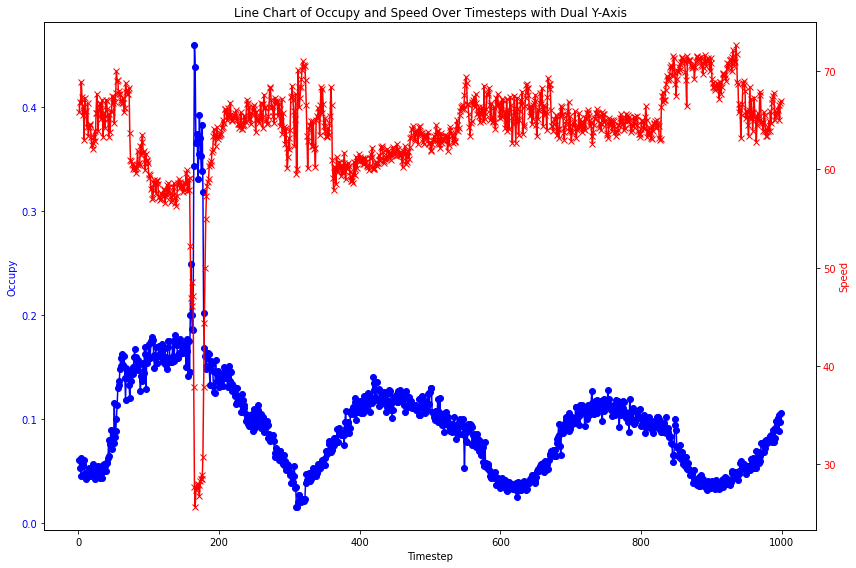

In [110]:
specifit_traffic = traffic[traffic['location']==0]
specifit_traffic = specifit_traffic[specifit_traffic['timestep'] < 1000]

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(specifit_traffic['timestep'], specifit_traffic['occupy'], color='b', marker='o', label='occupy')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Occupy', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(specifit_traffic['timestep'], specifit_traffic['speed'], color='r', marker='x', label='speed')
ax2.set_ylabel('Speed', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Line Chart of Occupy and Speed Over Timesteps with Dual Y-Axis')
fig.tight_layout()
plt.show()

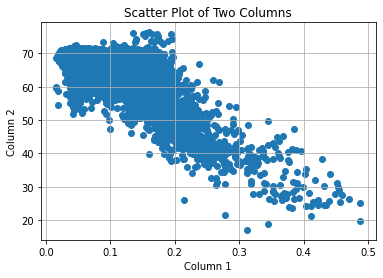

In [104]:
plt.scatter(specifit_traffic['occupy'], specifit_traffic['speed'])
plt.title('Scatter Plot of Two Columns')
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.grid(True)
plt.show()

In [100]:
# import plotly.express as px

# fig = px.scatter_3d(specifit_traffic, 
#                     x='occupy', 
#                     y='speed', 
#                     z='flow', 
#                     color='flow')

# fig.update_traces(marker=dict(size=1))

# fig.show()

3
17841
476055


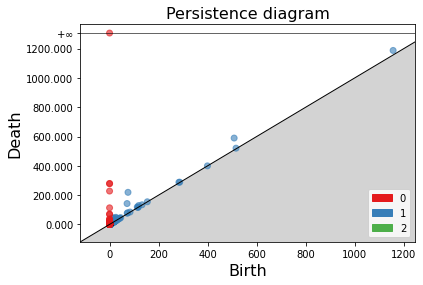

In [44]:
import gudhi as gd 

point = specifit_traffic[['flow', 'occupy', 'speed']].to_numpy()
alpha_complex = gd.AlphaComplex(points = point)
st_alpha = alpha_complex.create_simplex_tree()

print(st_alpha.dimension())
print(st_alpha.num_vertices())
print(st_alpha.num_simplices())

dgm = st_alpha.persistence()
gd.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [111]:
from gtda.time_series import SingleTakensEmbedding

x = specifit_traffic['occupy']

embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type = "fixed",
    n_jobs = -1,
    time_delay = 350,
    dimension = 2,
    stride = 1,
)

y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(x)
# plot_point_cloud(y_nonperiodic_embedded)